In [60]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy

from scipy import stats
from numba import njit

## Loading the data and obtaining a sort of profile histogram

- We first load the root file using uproot and show its contents

In [2]:
# Open the file and show its contents (like .ls in ROOT CERN)
t_hk_obox = ur.open("../data/Allaux_Bfield.root:t_hk_obox")
print(t_hk_obox.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | float                    | As

In [3]:
# Magnetic field information
B_field = ur.open("../data/Allaux_Bfield.root:B_field")
print(B_field.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
B_r                  | double                   | AsDtype('>f8')
B_theta              | double                   | AsDtype('>f8')
B_phi                | double                   | AsDtype('>f8')
None


- We can then obtain a dictionary where keys are some of the names shown above and values are numpy arrays containing the data. Note that we only keep a subset of the information

In [4]:
data_dict = t_hk_obox.arrays(["saa", 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               "obox_mode",
                               "fe_temp",
                               "glon", 
                               "glat",
                               "tunix",
                               "fe_cosmic",
                               "fe_rate"], library="np")
data_dict |=  B_field.arrays(["B_r", "B_theta", "B_phi"], library="np")

- We are interested in the following curve which contains a background part and the gamma ray bursts we would like to detect:

In [5]:
tunix = data_dict["tunix"]
sum_fe_rate = np.sum(data_dict["fe_rate"], axis=1)

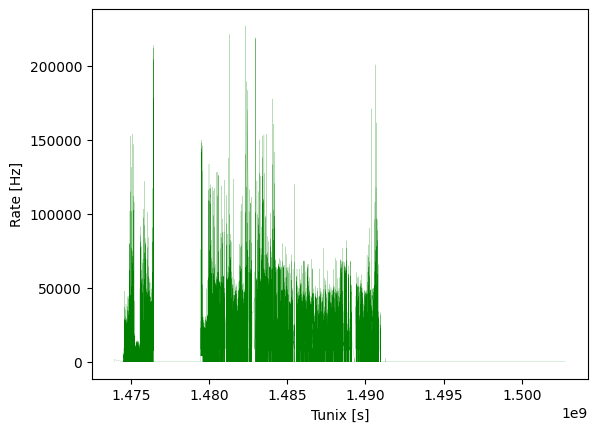

In [6]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # Nb. photons per second
plt.show()

Therefore, we would like to predict the background part, subtract it from the curve and analyze or use the remaining part to detect gamma ray bursts (GRB).

As we can see from the previous plot, we see a large flat region on the right with no data. We can therefore crop the right part:

In [7]:
last_non_zero = sum_fe_rate.size-(np.flip(sum_fe_rate)>0).argmax() - 1
tunix = tunix[:last_non_zero+1]
sum_fe_rate = sum_fe_rate[:last_non_zero+1]

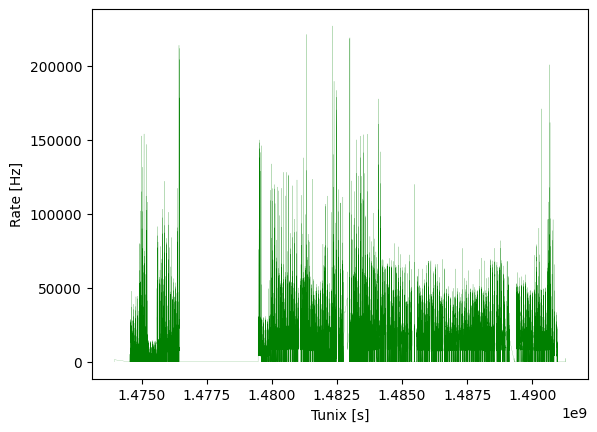

In [8]:
plt.plot(tunix, sum_fe_rate, 'g', linewidth=0.1)
plt.xlabel("Tunix [s]")
plt.ylabel("Rate [Hz]")  # Nb. photons per second
plt.show()

We can observe a lot of missing values due to the detector being switched off when astronauts went onboard the space station. Small missing values are due to the South Altantic Anomaly region.

- We can shift the time axis so that it starts at $0$. We can also bin the data

In [9]:
tunix_min = tunix.min()
tunix_shifted = tunix - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)

In [10]:
pd.DataFrame(bins[uniques_idx].reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,6187613,6187614,6187615,6187616,6187617,6187618,6187619,6187620,6187621,6187622
0,2.0,4.0,6.0,10.0,12.0,18.0,20.0,26.0,28.0,34.0,...,17323018.0,17323020.0,17323022.0,17323024.0,17323026.0,17323028.0,17323030.0,17323032.0,17323034.0,17323036.0


We can observe that the bins start at $2$ seconds and this should be taken into account in the future.

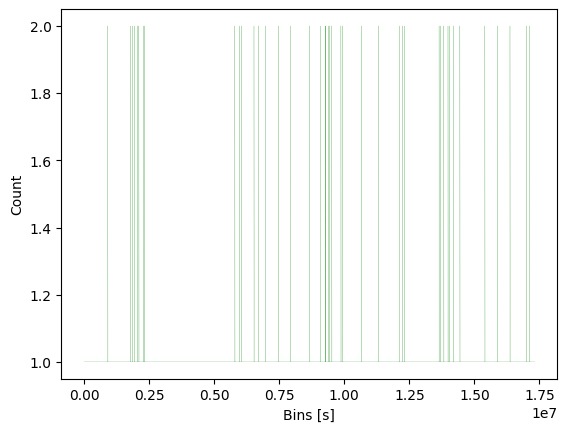

In [11]:
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

- There are sometimes two data points in a bin, we can average the data falling into each bin (profile hist but without error bars).

In [12]:
# Quantized Shifted Time
t = bins[indices_digitized]

# First column is the quantized time, second is the 'average' rate within the bin
light_curve = np.array(pd.DataFrame(np.vstack([t, sum_fe_rate, indices_digitized]).T, 
                                    columns=["t", "sum_fe_rate", "idx"]).groupby("idx").mean())

In [13]:
t, y = light_curve.T

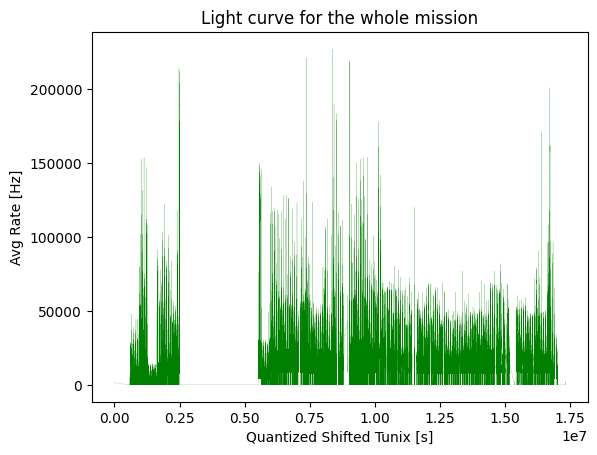

In [14]:
plt.plot(t, y, 'g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

- Let's show just a small part of it (not the whole mission):

In [15]:
t.shape, y.shape

((6187623,), (6187623,))

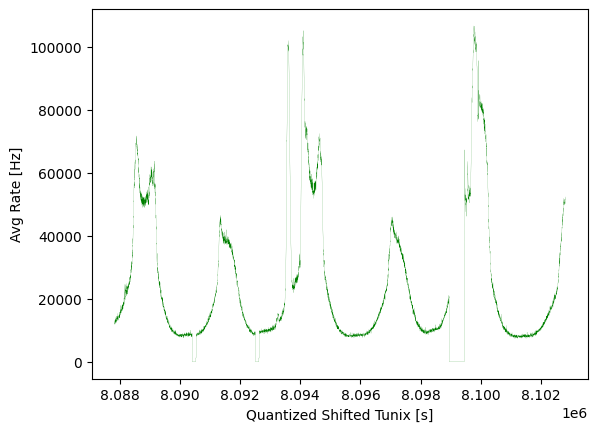

In [16]:
# Mask used to select a portion of the mission
mask = (t>(5000+1482032854-tunix_min)) & (t<(20000+1482032854-tunix_min))

plt.plot(t[mask], y[mask], '-g', linewidth=0.1)
plt.xlabel("Quantized Shifted Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # nb. photons per seconds (averaged over each bin)
plt.show()

---

## Fourier Transform

- Direct transform

In [17]:
fft_res = np.fft.rfft(y)
fft_res.shape

(3093812,)

In [18]:
t.shape

(6187623,)

- Frequency axis

In [19]:
freqs_tmp = np.fft.fftfreq(y.size, d=2)
pd.DataFrame(freqs_tmp.reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,6187613,6187614,6187615,6187616,6187617,6187618,6187619,6187620,6187621,6187622
0,0.0,8.080647e-08,1.616129e-07,2.424194e-07,3.232259e-07,4.040324e-07,4.848388e-07,5.656453e-07,6.464518e-07,7.272583e-07,...,-8.080647e-07,-7.272583e-07,-6.464518e-07,-5.656453e-07,-4.848388e-07,-4.040324e-07,-3.232259e-07,-2.424194e-07,-1.616129e-07,-8.080647e-08


In [20]:
pd.DataFrame(freqs_tmp[:y.size//2+2].reshape(1, -1))

,0,1,2,3,4,5,6,7,8,9,...,3093803,3093804,3093805,3093806,3093807,3093808,3093809,3093810,3093811,3093812
0,0.0,8.080647e-08,1.616129e-07,2.424194e-07,3.232259e-07,4.040324e-07,4.848388e-07,5.656453e-07,6.464518e-07,7.272583e-07,...,0.249999,0.249999,0.249999,0.25,0.25,0.25,0.25,0.25,0.25,-0.25


In [21]:
print(f"freqs_tmp[:y.size//2+1].size={freqs_tmp[:y.size//2+1].size}, fft_res.size={fft_res.size}")

freqs_tmp[:y.size//2+1].size=3093812, fft_res.size=3093812


In [22]:
freqs = freqs_tmp[:y.size//2+1]

In [23]:
def get_freqs_hour(freq):
    return 3600*freq

def get_freqs_after_first(n=None):
    # if n is not None, we select the n-1 freqs after the first
    if n is None:
        return freqs[1:]
    return freqs[1:np.minimum(freqs.size, n)]

def get_freqs(n=None):
    # if n is not None, we select the n first freqs
    if n is None:
        return freqs
    return freqs[:np.minimum(freqs.size, n)]

def f_after_first(n=None):
    return get_freqs_hour(get_freqs_after_first(n))

def f(n=None):
    return get_freqs_hour(get_freqs(n))

In [64]:
freqs_hour = get_freqs_hour(freqs)

- Plotting the magnitude and the phase (without the first one)

In [24]:
mag = np.abs(fft_res)
phase = np.angle(fft_res)

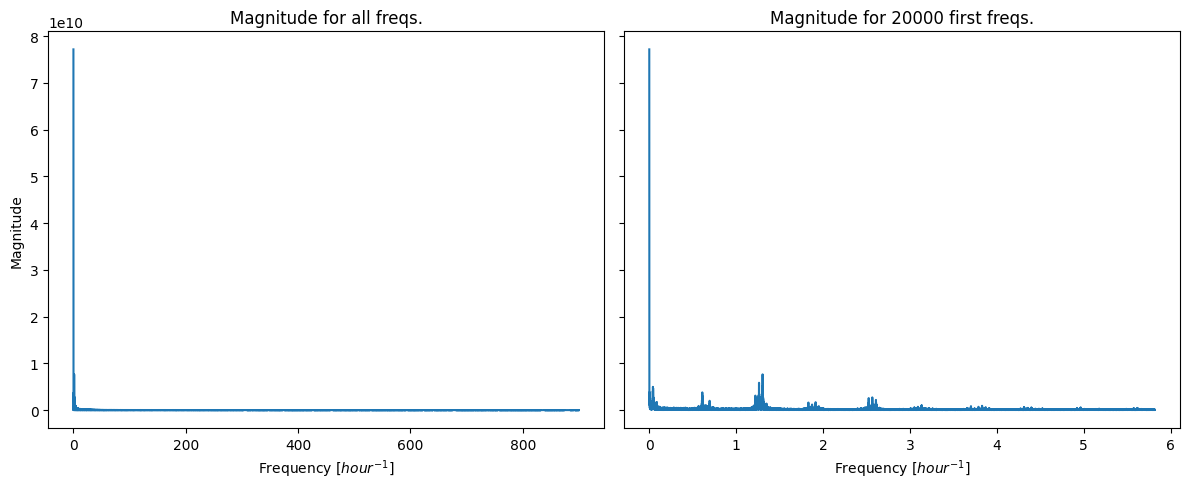

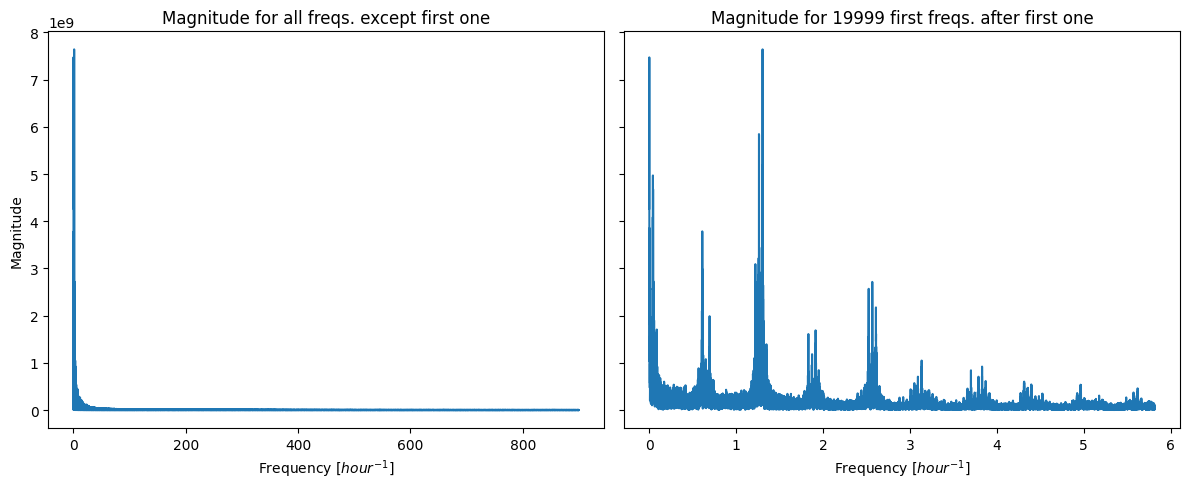

In [25]:
n = 20000  # number of frequencies to show

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].plot(f(), mag[:])
axs[0].set_xlabel(r"Frequency [$hour^{-1}$]")
axs[0].set_ylabel("Magnitude")
axs[0].set_title("Magnitude for all freqs.")

axs[1].plot(f(n), mag[:n])
axs[1].set_xlabel(r"Frequency [$hour^{-1}$]")
axs[1].set_title(f"Magnitude for {n} first freqs.")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), mag[1:])
axs2[0].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(f_after_first(n), mag[1:n])
axs2[1].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Phase (TODO, make it more interpretable):

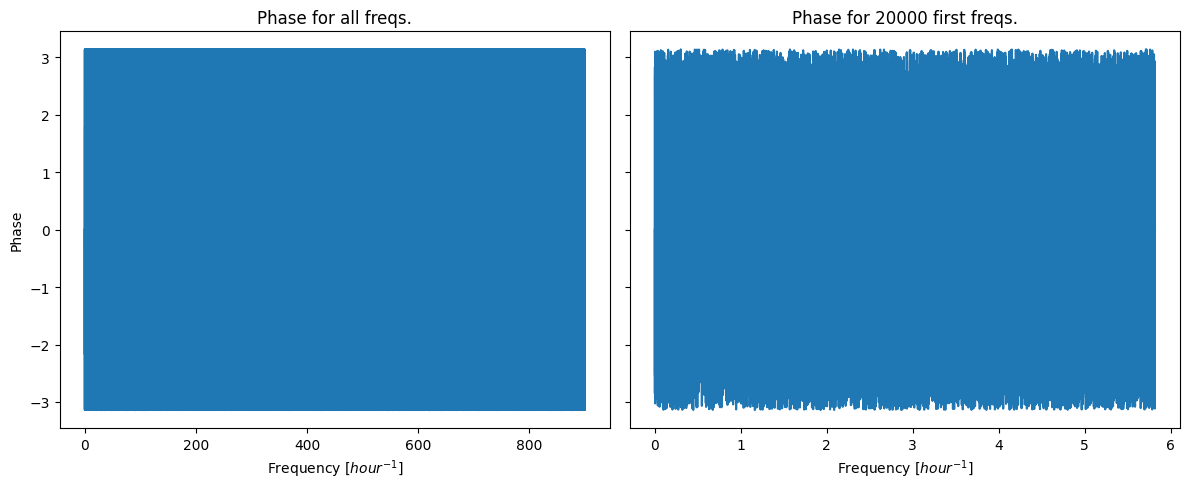

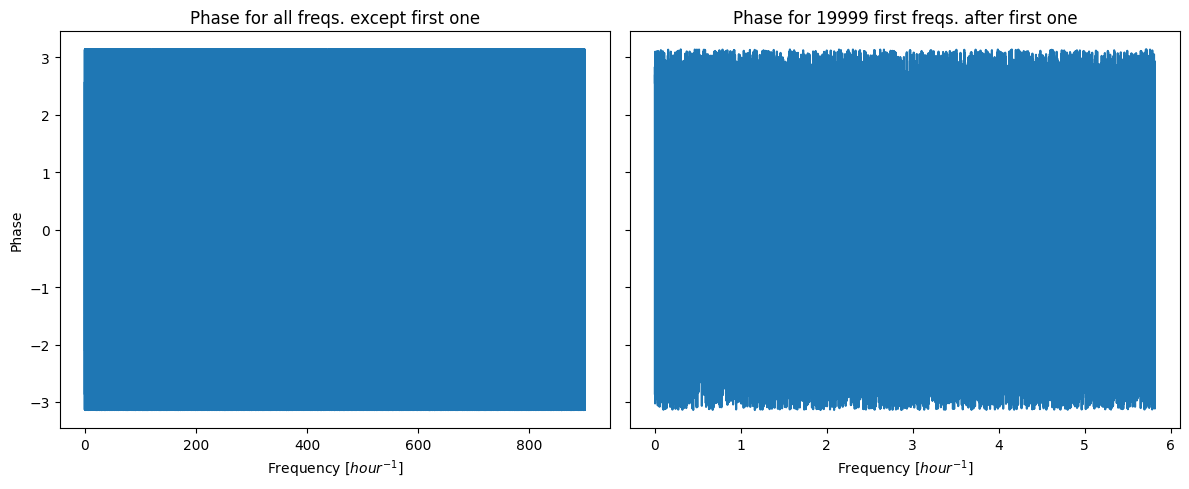

In [26]:
n = 20000  # number of frequencies to show

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs[0].plot(f(), phase[:])
axs[0].set_xlabel(r"Frequency [$hour^{-1}$]")
axs[0].set_ylabel("Phase")
axs[0].set_title("Phase for all freqs.")

axs[1].plot(f(n), phase[:n])
axs[1].set_xlabel(r"Frequency [$hour^{-1}$]")
axs[1].set_title(f"Phase for {n} first freqs.")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), phase[1:])
axs2[0].set_xlabel("Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Phase")
axs2[0].set_title("Phase for all freqs. except first one")

axs2[1].plot(f_after_first(n), phase[1:n])
axs2[1].set_xlabel("Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Phase for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Not very interpretable

And for even smaller subsets

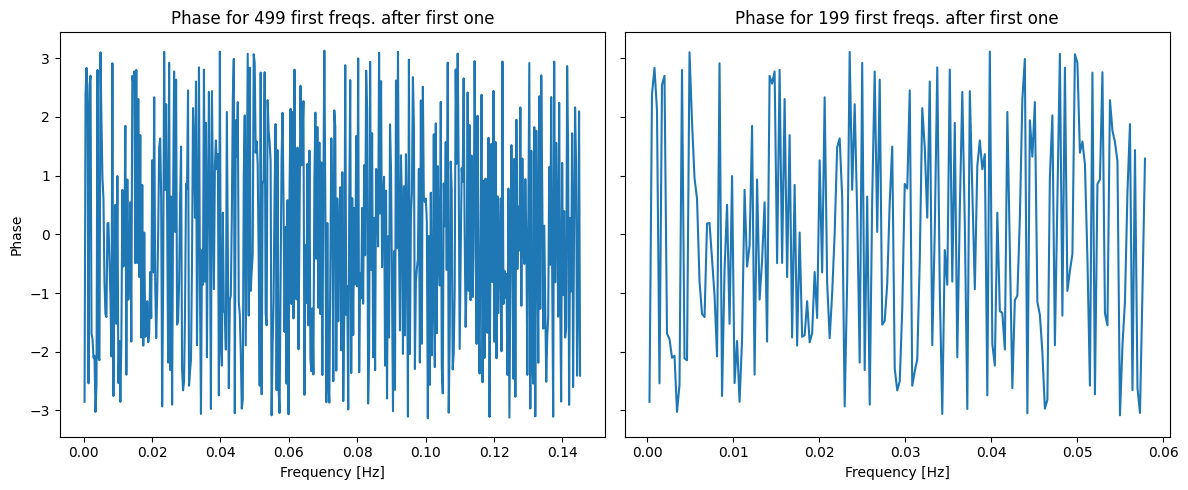

In [27]:
n = 500  # number of frequencies to show

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(n), phase[1:n])
axs2[0].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[0].set_ylabel("Phase")
axs2[0].set_title(f"Phase for {n-1} first freqs. after first one")

n = 200  # number of frequencies to show

axs2[1].plot(f_after_first(n), phase[1:n])
axs2[1].set_xlabel("Frequency [Hz]")  # TODO: fix the units ... per hour
axs2[1].set_title(f"Phase for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Placing a line at the mean:

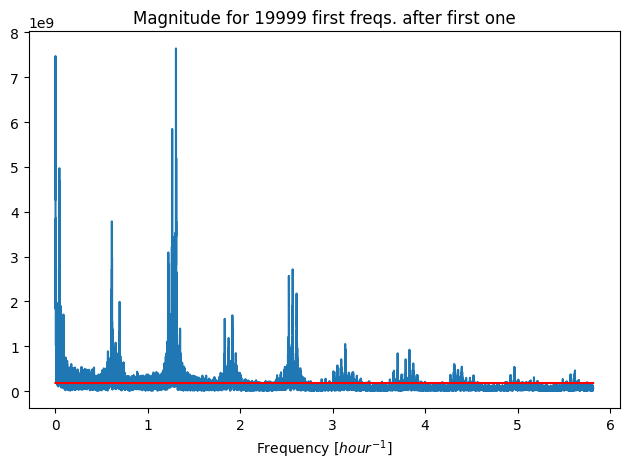

In [28]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(n), mag[1:n])
plt.plot(f_after_first(n),
         np.mean(mag[:n])*np.ones(n-1), 'r')
plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

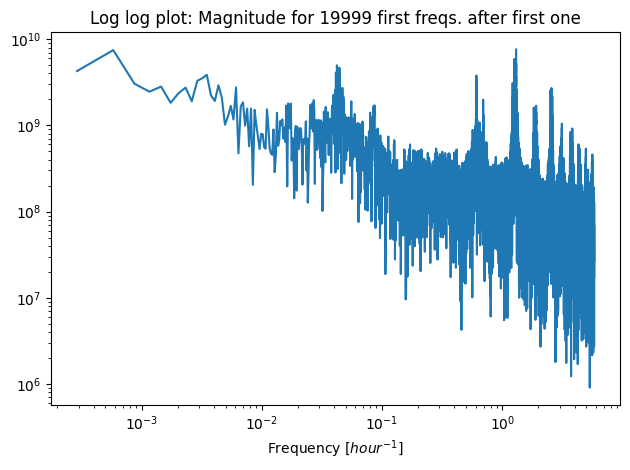

In [29]:
n = 20000  # number of frequencies to show

plt.loglog(f_after_first(n), mag[1:n])
plt.xlabel("Frequency [$hour^{-1}$]")  # TODO: fix the units ... per hour
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

Let's try to fit a power law and use it to apply local means on specific regions

In [30]:
x_tmp = np.log(f_after_first(n))
y_tmp = np.log(mag[1:n])

In [31]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x_tmp, y_tmp)
print(slope, intercept, r_value, p_value, std_err)

-0.4561899633444006 18.844238293990262 -0.4911029956949334 0.0 0.0057221532920807075


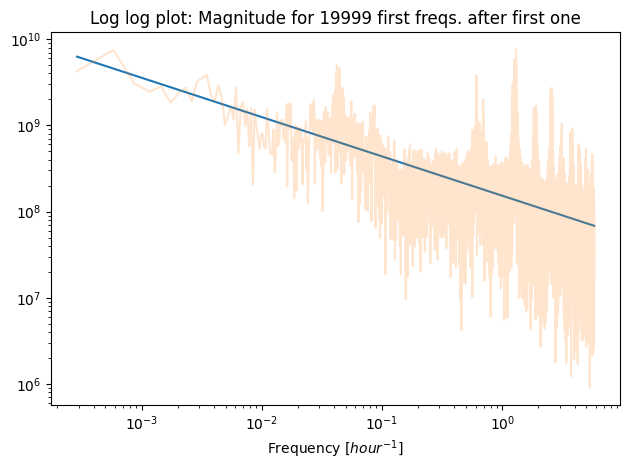

In [32]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(n),
         np.exp(slope*x_tmp + intercept),
         label="Linear regression 'using log'")

plt.loglog(f_after_first(n), mag[1:n],
          alpha=0.2)

plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Log log plot: Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()

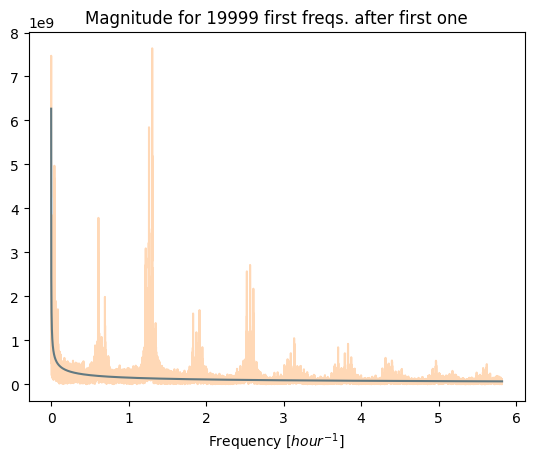

In [33]:
n = 20000  # number of frequencies to show

plt.plot(f_after_first(n),
         np.exp(slope*x_tmp + intercept),
         label="Linear regression 'using log'")

plt.plot(f_after_first(n), mag[1:n], alpha=0.3)

plt.xlabel("Frequency [$hour^{-1}$]")
plt.title(f"Magnitude for {n-1} first freqs. after first one")
plt.show()

In [34]:
fft_res.size

3093812

In [35]:
t.size

6187623

In [36]:
1/(2*3600)*1e5

13.88888888888889

## Convolution with box filter in Fourier domain

TODO: we wanted to kill the spikes in the magnitude and reconstruct back the signal

- Over the whole Fourier domain

In [37]:
window_size = 100
mag_convolved = np.convolve(mag, np.ones(window_size)/window_size, "same")
# TODO: only do it for the big spikes and try with different window lengths
# TODO: be careful about padding !!

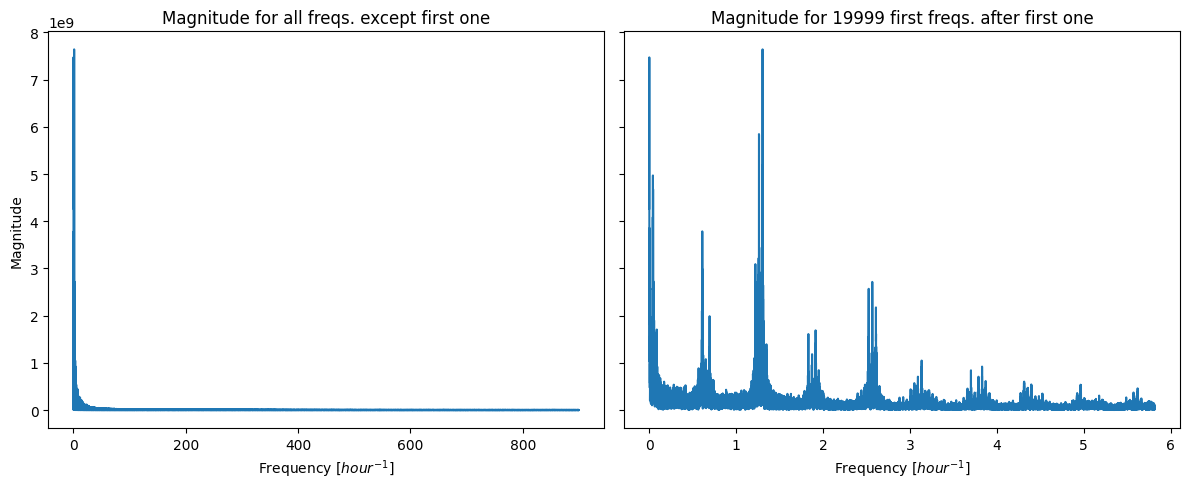

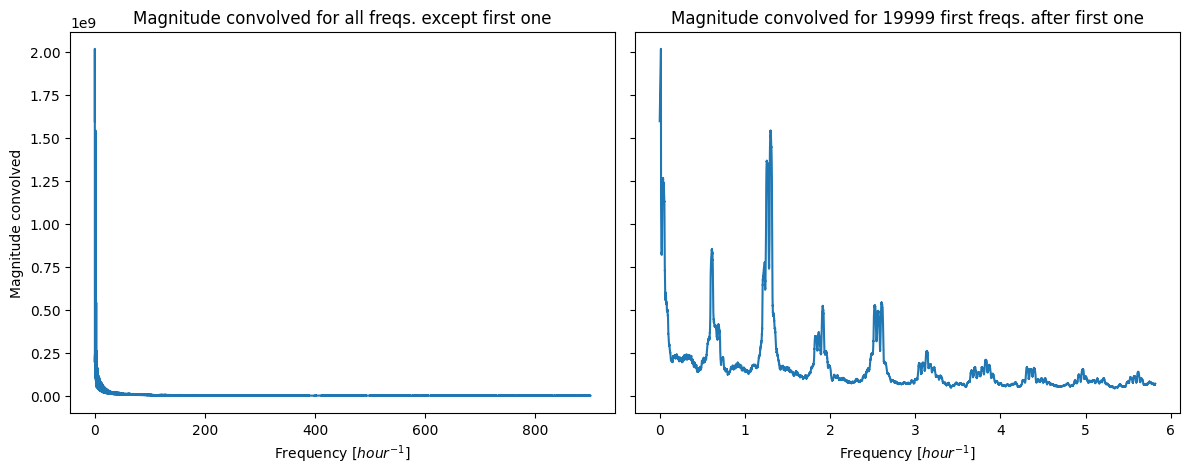

In [38]:
n = 20000  # number of frequencies to show

fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), mag[1:])
axs2[0].set_xlabel("Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(f_after_first(n), mag[1:n])
axs2[1].set_xlabel("Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()


fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), mag_convolved[1:])
axs2[0].set_xlabel("Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Magnitude convolved")
axs2[0].set_title("Magnitude convolved for all freqs. except first one")

axs2[1].plot(f_after_first(n), mag_convolved[1:n])
axs2[1].set_xlabel("Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Magnitude convolved for {n-1} first freqs. after first one")
plt.tight_layout()
plt.show()


In [39]:
t.shape, mag.shape

((6187623,), (3093812,))

In [40]:
reconstructed = np.fft.irfft(mag_convolved*np.exp(1j*np.angle(fft_res)), n=y.size)

In [41]:
reconstructed.shape

(6187623,)

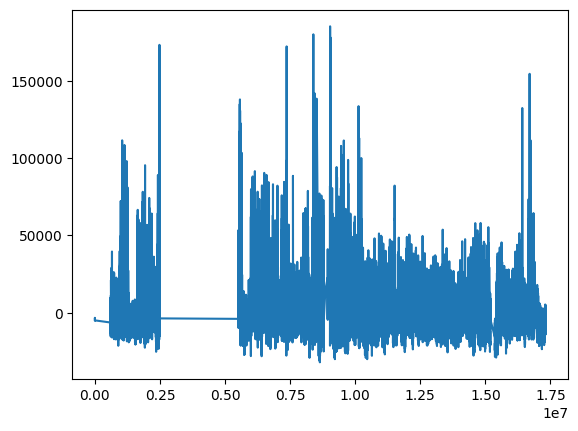

In [91]:
plt.plot(t, reconstructed)
plt.show()

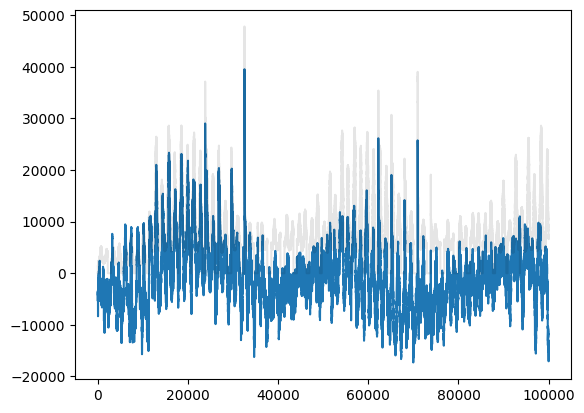

In [92]:
plt.plot(reconstructed[:100000])
plt.plot(y[:100000], 'k', alpha=0.1)

In [44]:
fft_res.shape

(3093812,)

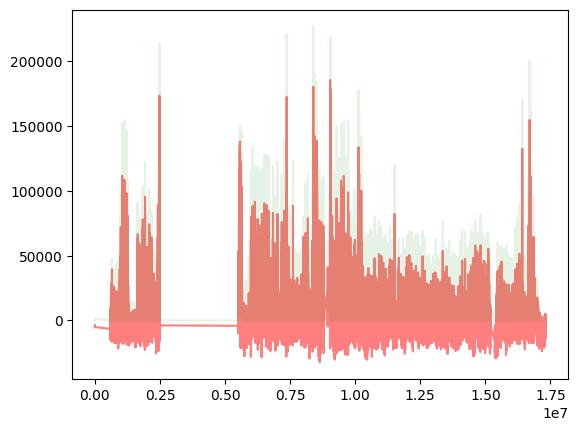

In [45]:
plt.plot(t, reconstructed, 'r', alpha=0.5)
plt.plot(t, y, 'g', alpha=0.1)

Values below zero doesn't make any sense physically (counts)

In [46]:
reconstructed.size

6187623

In [47]:
y.size

6187623

In [48]:
print(t.min(), t.max())  # TODO: need to take this into account 

2.0 17323036.0


## Killing low frequencies instead..


TODO: we wanted to kill the spikes in the magnitude and reconstruct back the signal but now we want to keep most them except the beginning..

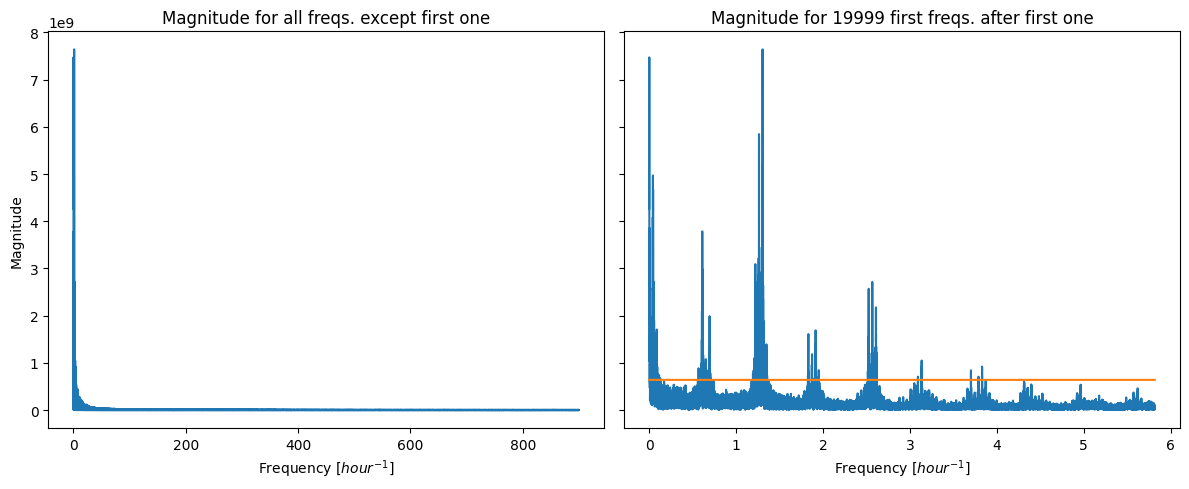

In [59]:
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), mag[1:])
axs2[0].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(f_after_first(n), mag[1:n])
axs2[1].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")

axs2[1].plot(f_after_first(n), np.ones(n-1)*0.64*1e9)  # threshold placed visually..
plt.tight_layout()
plt.show()

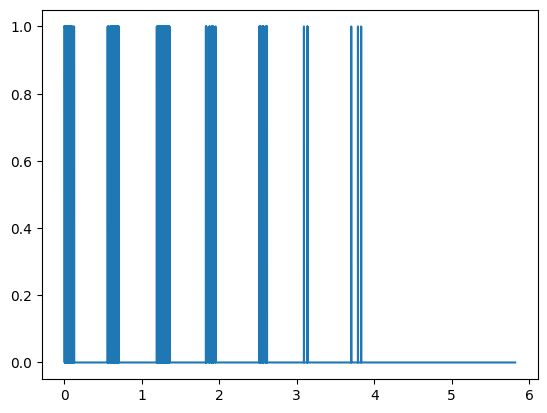

In [65]:
plt.plot(freqs_hour[:n], mag[:n] > 0.64*1e9)

In [88]:
cropped_fft_res = copy.deepcopy(fft_res)
cropped_fft_res[freqs_hour<=1] = 0
cropped_fft_res[:np.argmax(np.abs(cropped_fft_res)>0.64*1e9)] = 0

In [89]:
freqs

array([0.00000000e+00, 8.08064745e-08, 1.61612949e-07, ...,
       2.49999798e-01, 2.49999879e-01, 2.49999960e-01])

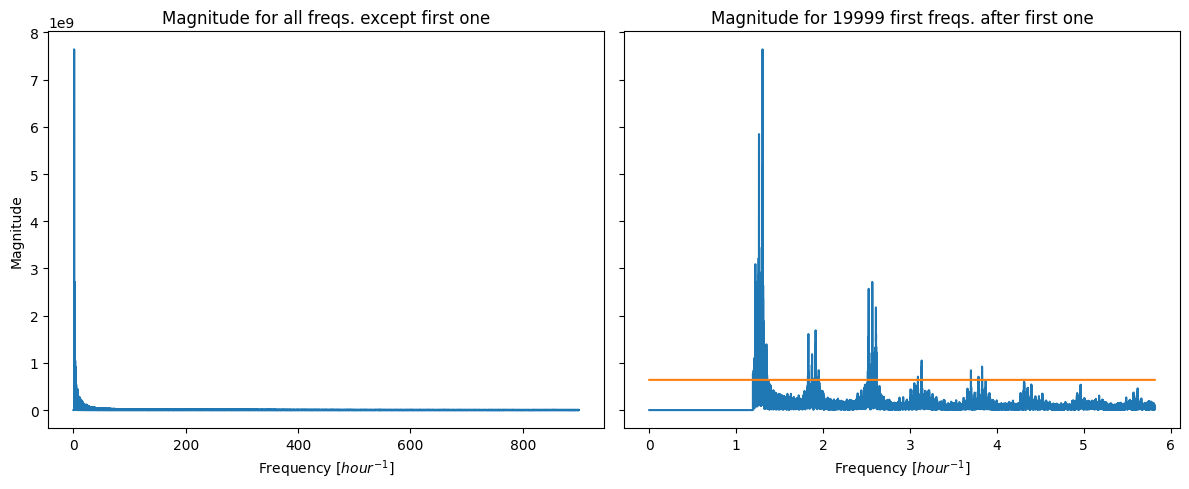

In [90]:
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axs2[0].plot(f_after_first(), np.abs(cropped_fft_res)[1:])
axs2[0].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[0].set_ylabel("Magnitude")
axs2[0].set_title("Magnitude for all freqs. except first one")

axs2[1].plot(f_after_first(n), np.abs(cropped_fft_res)[1:n])
axs2[1].set_xlabel(r"Frequency [$hour^{-1}$]")
axs2[1].set_title(f"Magnitude for {n-1} first freqs. after first one")

axs2[1].plot(f_after_first(n), np.ones(n-1)*0.64*1e9)  # threshold placed visually..
plt.tight_layout()
plt.show()

- Apply Fourier synthesis to get back a reconstructed signal.

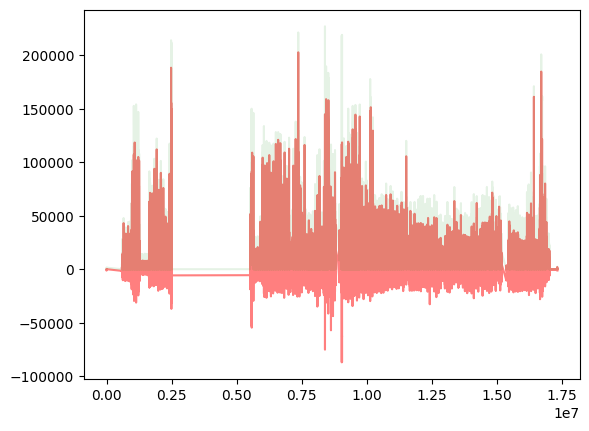

In [93]:
y_hat = np.fft.irfft(cropped_fft_res, n=y.size)

plt.plot(t, y_hat, 'r', alpha=0.5)
plt.plot(t, y, 'g', alpha=0.1)